# Map Making use case - Data Access

The tutorial focuses on the accessing and visualizing the prediction results derived from the **Map Making** use case. </br>
The results are also available on the Map Viewer which can be accessed using this **[link](https://www.globalearthmonitor.eu/sites/default/files/water/index.html)**.

The predictions are stored in _[BYOC SentinelHub layers](https://docs.sentinel-hub.com/api/latest/data/byoc/)_. 
Here are the details of the layers and bands to access the data:

| **Layer**                          | **Region**                      | **Resolution** | **SH Collection Id**                 | **Raster Band** |
| ---------------------------------- | ------------------------------- | -------------- | ------------------------------------ | --------------- |
| Water Demo AOIs Prediction 2019    | All AOIs mentioned in table 2.4 | 10m            | f234133c-d198-4569-a14f-612d692f2030 | PRED            |
| Probabilities for PW 2019          | Chile AOI                       | 10m            | 6da384a4-1ea1-40a6-b855-0b4ad954671f | PW              |
| Probabilities for IW 2019          | Chile AOI                       | 10m            | 6da384a4-1ea1-40a6-b855-0b4ad954671f | IW              |
| Water CNN Gap Filling Predictions  | Myanmar AOI                     | 10m            | b31d5c95-ddb6-440f-b732-5827f5f64fb7 | PRED            |
| Water Experiments Predictions 2020 | Myanmar AOI                     | 10m            | 742682e8-ab52-46b6-bfa8-6fc068cb60cf | PRED            |

In [5]:
# imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from eolearn.core import FeatureType
from eolearn.io import SentinelHubInputTask
from sentinelhub import CRS, Band, BBox, DataCollection, Unit

# Pilot region results
**Input Data**
- Sentinel-2 L2A : Bands B1 to B12
- Yearly data , aggregated every two months
- Generate predictions yearly
- Predictions at 10m resolution

**Model**
- Pixel Based LGBMClassifier : GBDT
- 3 Classes

Below table shows the value of water classes in Predictions and which colors are used to display them:

| **Class**          | **Value** | **Visualization Color** |
| ------------------ | --------- | ----------------------- |
| Permanent Water    | 1         | Dark Blue               |
| Intermittent Water | 2         | Sky Blue                |
| Rest               | 3         | White                   |



In [6]:
# The data is stored in the band named 'PRED'
# Create a byoc collection to access the data
bands = ["PRED"]

byoc_collection = DataCollection.define_byoc(
    "f234133c-d198-4569-a14f-612d692f2030",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in bands],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

In [7]:
# Create a task that will download the data from the BYOC service
predictions_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "pred"),
    data_collection=byoc_collection,
    bands=bands,
    resolution=10,
    max_threads=3,
)

In [8]:
# we choose a bounding box that covers a small area in Uruguay
uruguay_bbox = BBox((452100.0, 6328700.0, 474000.0, 6350700.0), CRS.UTM_21S)
eopatch = predictions_download_task.execute(bbox=uruguay_bbox)  # , time_interval=["2019-01-01", "2023-01-01"]

/opt/conda/envs/gem_data_notebooks/lib/python3.9/site-packages/eolearn/io/sentinelhub_process.py:558: TemporalDimensionWarning: Adding temporal feature (<FeatureType.DATA: 'data'>, 'pred') to EOPatch without a temporal definition (no timestamps).
  eopatch[bands_feature] = np.concatenate(processed_bands, axis=-1)


In [9]:
# This function will be used to visualize the data as RGB image, The Color mapping is shown above.
def transform_to_rgb(preds):
    """
    Function to transform the predictions to RGB for visualization
    """
    ids_to_rgb = {0: [255, 255, 255], 1: [50, 74, 221], 2: [140, 203, 255], 3: [255, 255, 255]}
    resulr_arr = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)
    for id, mapping in ids_to_rgb.items():
        resulr_arr[np.where(preds == id)] = np.array(mapping)
    return resulr_arr

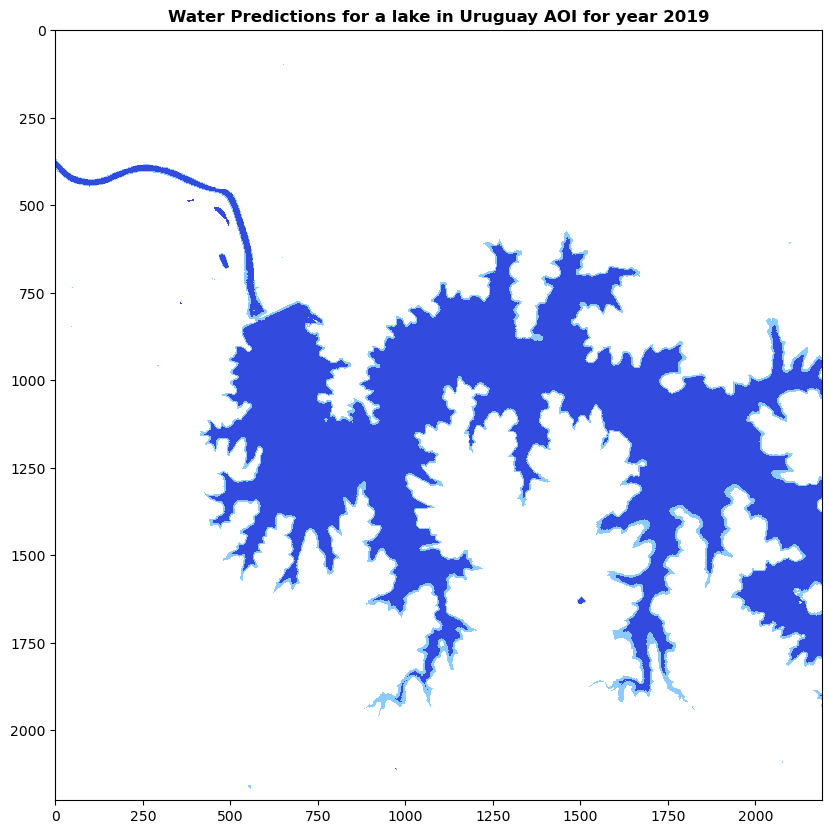

In [10]:
# Generate a plot for each year
#  we visualize the predictions using transform_to_rgb function
preds_data = eopatch.data["pred"].astype(int).squeeze()

fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.set_title("Water Predictions for a lake in Uruguay AOI for year 2019", fontweight="bold")
ax1.imshow(transform_to_rgb(preds_data), interpolation="nearest")

## Probabilities for the prediciton
Following code snippet shows how to visulize the prediction probabilities of individual classes using a LCGM classifier model

In [37]:
# Probabilities are stored in a separate collection with bands named 'PW' and 'IW'
bands = ["PW", "IW"]
pred_collection_id = "6da384a4-1ea1-40a6-b855-0b4ad954671f"

byoc_collection = DataCollection.define_byoc(
    pred_collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in bands],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

# Create a task that will download the data from the BYOC service
proba_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "pred"),
    data_collection=byoc_collection,
    bands=bands,
    resolution=10,
    max_threads=3,
)

eopatch_prob = proba_download_task.execute(bbox=uruguay_bbox)

/opt/conda/envs/gem_data_notebooks/lib/python3.9/site-packages/eolearn/io/sentinelhub_process.py:558: TemporalDimensionWarning: Adding temporal feature (<FeatureType.DATA: 'data'>, 'pred') to EOPatch without a temporal definition (no timestamps).
  eopatch[bands_feature] = np.concatenate(processed_bands, axis=-1)


In [20]:
# Visualize the probabilities for each class
proba_data = eopatch_prob.data["pred"].squeeze()

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
ax1, ax2 = axes
# get colormap for reds
reds_cmap = matplotlib.cm.get_cmap("Reds")
ax1.imshow(proba_data[:, :, 0], interpolation="nearest", cmap=reds_cmap)
ax1.set_title("Permanent Water probabilities", fontweight="bold")
ax2.imshow(proba_data[:, :, 1], interpolation="nearest", cmap=reds_cmap)
ax2.set_title("Intermittent Water probabilities", fontweight="bold")
plt.suptitle("Water Predictions for a lake in Urugway AOI", y=0.95, fontweight="bold", fontsize=15)

## Myanmar AOI experiments
We also performed various experiments in Maynmar for fine-tuning and evaluating the Classifier performance. </br>
Following code snippets show how the data can be accessed and visualized.

### Gap Filling Model
In addition to Tuning the model, we also experimented with a Gap Filling model, which can be used to fill gaps after classification using a CNN Image Segmentation model. </br>

In [11]:
# myanmar bbox object
myanmar_bbox = BBox((530500.0, 2302200.0, 533700.0, 2305400.0), CRS.UTM_46N)

In [12]:
# The data for three years are stored as separate bands with following band names
bands = ["PRED"]

pred_collection_id = "b31d5c95-ddb6-440f-b732-5827f5f64fb7"
byoc_collection = DataCollection.define_byoc(
    pred_collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in bands],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

# Create a task that will download the data from the BYOC service
pred_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "pred"),
    data_collection=byoc_collection,
    bands=bands,
    resolution=10,
    max_threads=3,
)

cnn_pred = pred_download_task.execute(bbox=myanmar_bbox).data["pred"].astype(int).squeeze()

/opt/conda/envs/gem_data_notebooks/lib/python3.9/site-packages/eolearn/io/sentinelhub_process.py:558: TemporalDimensionWarning: Adding temporal feature (<FeatureType.DATA: 'data'>, 'pred') to EOPatch without a temporal definition (no timestamps).
  eopatch[bands_feature] = np.concatenate(processed_bands, axis=-1)


In [13]:
bands = ["PRED"]
pred_collection_id = "742682e8-ab52-46b6-bfa8-6fc068cb60cf"
byoc_collection = DataCollection.define_byoc(
    pred_collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in bands],
    metabands=[Band(name="dataMask", units=(Unit.DN,), output_types=(bool,))],
)

# Create a task that will download the data from the BYOC service
pred_download_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "pred"),
    data_collection=byoc_collection,
    bands=bands,
    resolution=10,
    max_threads=3,
)

lgbm_pred = pred_download_task.execute(bbox=myanmar_bbox).data["pred"].astype(int).squeeze()

/opt/conda/envs/gem_data_notebooks/lib/python3.9/site-packages/eolearn/io/sentinelhub_process.py:558: TemporalDimensionWarning: Adding temporal feature (<FeatureType.DATA: 'data'>, 'pred') to EOPatch without a temporal definition (no timestamps).
  eopatch[bands_feature] = np.concatenate(processed_bands, axis=-1)


### Visulize side by side
We visulize the output of LGBM classifier and the Gap Filling model applied on the same region.

Text(0.5, 0.95, 'Water Predictions for a lake in Myanmar AOI')

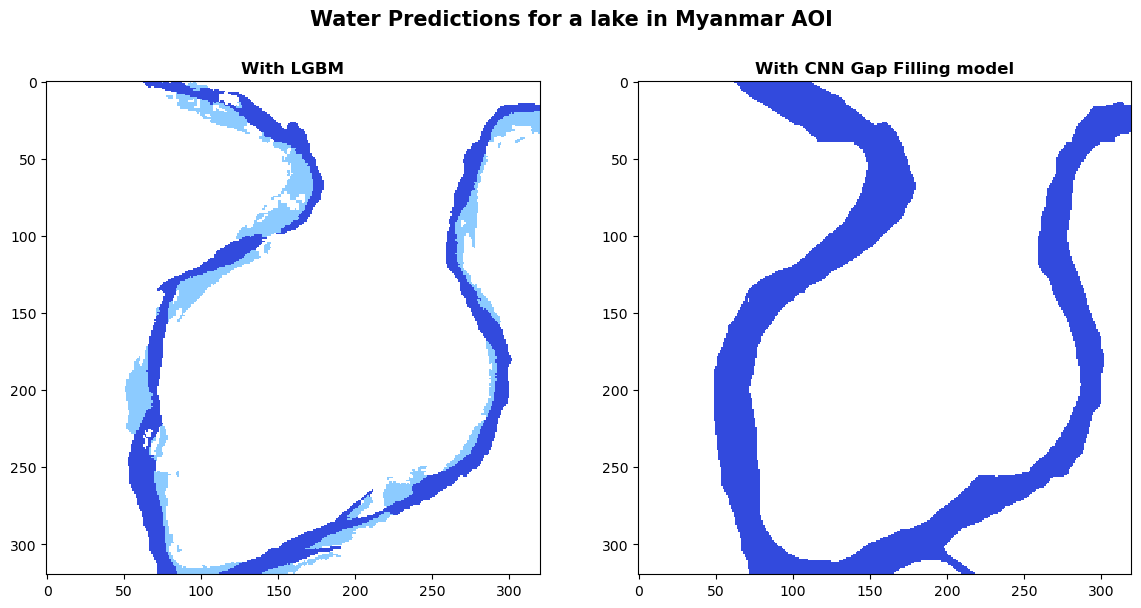

In [14]:
# Generate a plot for each year
#  we visualize the predictions using transform_to_rgb function
preds_data = eopatch.data["pred"].astype(int).squeeze()

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
ax1, ax2 = axes
ax1.set_title("With LGBM", fontweight="bold")
ax1.imshow(transform_to_rgb(lgbm_pred), interpolation="nearest")
ax2.set_title("With CNN Gap Filling model", fontweight="bold")
ax2.imshow(transform_to_rgb(cnn_pred), interpolation="nearest")
plt.suptitle("Water Predictions for a lake in Myanmar AOI", y=0.95, fontweight="bold", fontsize=15)